In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import os
from google.colab import drive

import cv2

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/My Drive/6721 Project dataset/'
print(os.listdir(path))

['Indian Traffic Signs Prediction(85 classes)', 'Persian Traffic Sign Dataset (PTSD)', 'Traffic Signs (GTSRB plus 162 custom classes)']


In [4]:
path_dataset1 = path+"Indian Traffic Signs Prediction(85 classes)/"
path_dataset2 = path+"Persian Traffic Sign Dataset (PTSD)/"
path_dataset3 = path+"Traffic Signs (GTSRB plus 162 custom classes)/Data_images/"

**Exploratory Data Analysis**

---



In [ ]:
# gather original number of classes in each dataset

In [5]:
def get_image_size_dist(path):
    t1 = time.time()

    folders = os.listdir(path)

    for folder in folders:

        img_x=[]
        img_y=[]

        samples = os.listdir(path+folder)

        # for sample in samples:
            # img = cv2.imread(path+folder+"/"+sample)

            # img_x.append(img.shape[0])
            # img_y.append(img.shape[1])

        print("Class: {} has samples: {} ".format(folder,len(samples)))
        # plt.scatter(img_x, img_y)
        # plt.show()

    print("\nTime taken: {}".format(time.time()-t1))

Dataset 1: Indian Traffic Signs Prediction(85 classes)

In [6]:
train_path = path_dataset1+"train/"
test_path = path_dataset1+"test/"

In [7]:
get_image_size_dist(train_path)

Class: CROSS_ROAD has samples: 140 
Class: GAP_IN_MEDIAN has samples: 180 
Class: COMPULSARY_KEEP_RIGHT has samples: 223 
Class: HORN_PROHIBITED has samples: 160 
Class: HUMP_OR_ROUGH_ROAD has samples: 101 
Class: LEFT_TURN_PROHIBITED has samples: 126 
Class: NO_ENTRY has samples: 174 
Class: NO_STOPPING_OR_STANDING has samples: 242 
Class: PEDESTRIAN_CROSSING has samples: 121 
Class: SPEED_LIMIT_40 has samples: 170 
Class: SPEED_LIMIT_80 has samples: 192 
Class: SPEED_LIMIT_30 has samples: 238 
Class: SPEED_LIMIT_50 has samples: 200 
Class: SPEED_LIMIT_60 has samples: 190 
Class: SPEED_LIMIT_70 has samples: 160 

Time taken: 5.863329887390137


In [8]:
get_image_size_dist(test_path)

Class: GAP_IN_MEDIAN has samples: 24 
Class: LEFT_TURN_PROHIBITED has samples: 43 
Class: CROSS_ROAD has samples: 32 
Class: HUMP_OR_ROUGH_ROAD has samples: 16 
Class: HORN_PROHIBITED has samples: 17 
Class: COMPULSARY_KEEP_RIGHT has samples: 12 
Class: NO_ENTRY has samples: 58 
Class: NO_STOPPING_OR_STANDING has samples: 81 
Class: PEDESTRIAN_CROSSING has samples: 41 
Class: SPEED_LIMIT_30 has samples: 80 
Class: SPEED_LIMIT_80 has samples: 64 
Class: SPEED_LIMIT_40 has samples: 57 
Class: SPEED_LIMIT_50 has samples: 67 
Class: SPEED_LIMIT_60 has samples: 64 
Class: SPEED_LIMIT_70 has samples: 54 

Time taken: 3.411684274673462


Dataset 2: Persian Traffic Sign Dataset (PTSD)

In [ ]:
train_path = path_dataset2+"train/"
test_path = path_dataset2+"test/"

In [ ]:
get_image_size_dist(train_path)

In [ ]:
get_image_size_dist(test_path)

Dataset 3: Traffic Signs (GTSRB plus 162 custom classes)

In [ ]:
train_path = path_dataset3+"Train/"
test_path = path_dataset3+"Test/"

Class: 10 has samples: 2003 


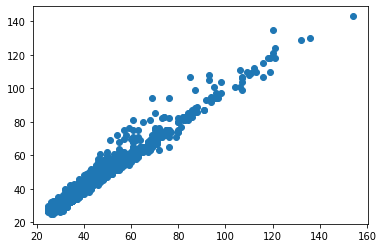

Class: 13 has samples: 2153 


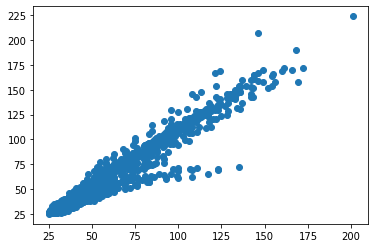

Class: 130 has samples: 1541 


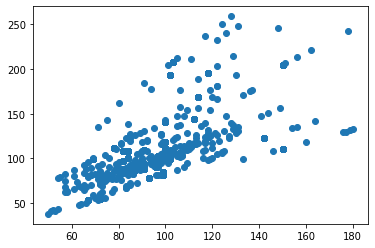

KeyboardInterrupt: ignored

In [ ]:
get_image_size_dist(train_path)

In [ ]:
get_image_size_dist(test_path)

**Data Loaders**

---



In [9]:
def load_data(path_train, val_split, path_test, batch_size, input_size):
  
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform_train= transforms.Compose([transforms.Resize(input_size),
                                          #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                                          transforms.ToTensor(),
                                          normalize
                                          ])

    transform_test = transforms.Compose([transforms.Resize(input_size),
                                         transforms.ToTensor(), 
                                         normalize])

    data_train = datasets.ImageFolder(root=path_train, transform=transform_train)
    data_test = datasets.ImageFolder(root=path_test, transform=transform_test)
    
    val_size = int(len(data_train)*val_split)
    train_size = len(data_train) - val_size

    train_dataset, val_dataset = td.random_split(data_train, [train_size, val_size])
    
    data_loader_train = td.DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False,
                                      num_workers=0,       
                                      pin_memory=True) 
     
    data_loader_val = td.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=False,
                                    num_workers=0)  
      
    data_loader_test = td.DataLoader(data_test,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   drop_last=False,
                                   num_workers=0)
    
    return data_loader_train, data_loader_test, data_loader_val

Training Setup

---



In [10]:
def train_model(model, num_epochs, train_loader, criterion, optimizer):

      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)

      total_steps = len(train_loader)

      t1 = time.time()

      for epoch in range(num_epochs):
          for i, data in enumerate(train_loader):
              
              images, labels = data[0].to(device), data[1].to(device)
              
              model.train()

              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              
              # Train accuracy
              total = labels.size(0)
              _, predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              
              if (i + 1) % 10 == 0:
                  model.eval() 
                  with torch.no_grad(): 
                      correctv = 0
                      totalv = 0
                      for datav in val_loader:
                          imagesv, labelsv = datav[0].to(device), datav[1].to(device)
                          outputsv = model(imagesv)
                          _, predictedv = torch.max(outputsv.data, 1)
                          totalv += labelsv.size(0)
                          correctv += (predictedv == labelsv).sum().item()
                          
                      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                          (correct / total) * 100,
                          (correctv / totalv) * 100))
                      
                  
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

      return model, device

In [11]:
def evaluate_model(model, test_loader, device):
   
    model.eval() 

    with torch.no_grad(): 
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the {} test images: {} %'
            .format(total, (correct / total) * 100))

Architecture 1: AlexNet

In [ ]:
nclasses=15

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', weights=None)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
prev_out = AlexNet_model.classifier[4].out_features
AlexNet_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [ ]:
AlexNet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset1+"train"
path_test = path_dataset1+"test"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
num_epochs = 20

trained_AlexNet_model, device = train_model(AlexNet_model, num_epochs, train_loader, criterion, optimizer)

Device: cuda:0
Epoch [1/1], Step [10/66], Loss: 2.7568, Accuracy: 0.00%, Validation Accuracy: 10.33%
Epoch [1/1], Step [20/66], Loss: 2.6704, Accuracy: 0.00%, Validation Accuracy: 10.33%
Epoch [1/1], Step [30/66], Loss: 2.6873, Accuracy: 9.38%, Validation Accuracy: 9.18%
Epoch [1/1], Step [40/66], Loss: 2.6864, Accuracy: 15.62%, Validation Accuracy: 9.18%
Epoch [1/1], Step [50/66], Loss: 2.6760, Accuracy: 3.12%, Validation Accuracy: 9.18%
Epoch [1/1], Step [60/66], Loss: 2.5726, Accuracy: 15.62%, Validation Accuracy: 15.30%
######## Training Finished in 235.3470482826233 seconds ###########


In [ ]:
torch.save(trained_AlexNet_model.state_dict(), path+"alexnetmodel.pt")

In [ ]:
evaluate_model(trained_AlexNet_model, test_loader, device)

Test Accuracy of the model on the 710 test images: 19.859154929577468 %


In [ ]:
# trained_AlexNet_model.load_state_dict(torch.load(path+"alexnetmodel.pt"))

Architecture 2: VGG-11

In [14]:
nclasses=15

In [15]:
VGG11_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', weights=None)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [17]:
prev_out = VGG11_model.classifier[3].out_features
VGG11_model.classifier[6] = nn.Linear(prev_out, nclasses)

In [18]:
VGG11_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(VGG11_model.parameters(), lr=learning_rate) 

In [ ]:
path_train = path_dataset1+"train"
path_test = path_dataset1+"test"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
num_epochs = 20

trained_VGG11_model, device = train_model(VGG11_model, num_epochs, train_loader, criterion, optimizer)

In [ ]:
torch.save(trained_VGG11_model.state_dict(), path+"vgg11model.pt")

In [ ]:
evaluate_model(trained_VGG11_model, test_loader, device)